In [5]:
%load_ext autoreload
%autoreload 2

from os import path, listdir
import urllib.request
import json
from collections import Counter
import copy

from tqdm import tqdm_notebook as tqdm

import spacy

import standoffconverter
import geo_helper
import iso3166

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lxml import etree

import ELTeC_dataloader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
file_names = [fn for fn in ELTeC_dataloader.get_file_descriptors()]

downloading https://github.com/COST-ELTeC/ELTeC-fra/trunk/level1


In [11]:
IN_DIR = file_names[0].split("/ELTeC-fra/")[0] + "/ELTeC-fra/"
file_names = [fn.split[IN_DIR][1] for fn in file_names]
file_names

NameError: name 'filenames' is not defined

# Spacy & TEI

## Standoff Converter

In [9]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
from IPython.display import HTML, display
import tabulate

display(HTML(tabulate.tabulate(chunks(sorted(file_names, key=lambda x:x.split("_")[1]), 6), tablefmt='html')))

downloads/ELTeC-fra/FRA0311_Aimard.xml,downloads/ELTeC-fra/FRA0302_Aimard.xml,downloads/ELTeC-fra/FRA0301_Aimard.xml,downloads/ELTeC-fra/FRA0322_Allais.xml,downloads/ELTeC-fra/FRA0322_Allais.xml~,downloads/ELTeC-fra/FRA0206_Audoux.xml
downloads/ELTeC-fra/FRA0562_Balzac.xml,downloads/ELTeC-fra/FRA0570_Balzac.xml,downloads/ELTeC-fra/FRA0572_Balzac.xml,downloads/ELTeC-fra/FRA1005_Boisgobey.xml,downloads/ELTeC-fra/FRA1003_Boisgobey.xml,downloads/ELTeC-fra/FRA1184_Boisgobey.xml
downloads/ELTeC-fra/FRA0020_Daudet.xml,downloads/ELTeC-fra/FRA0019_Daudet.xml,downloads/ELTeC-fra/FRA0021_Daudet.xml,downloads/ELTeC-fra/FRA0344_Dombre.xml,downloads/ELTeC-fra/FRA0343_Dombre.xml,downloads/ELTeC-fra/FRA0345_Dombre.xml
downloads/ELTeC-fra/FRA0037_Erckmann.xml,downloads/ELTeC-fra/FRA0038_Erckmann.xml,downloads/ELTeC-fra/FRA0027_Erckmann.xml,downloads/ELTeC-fra/FRA0615_Feval.xml,downloads/ELTeC-fra/FRA0607_Feval.xml,downloads/ELTeC-fra/FRA0605_Feval.xml
downloads/ELTeC-fra/FRA0042_Flaubert.xml,downloads/ELTeC-fra/FRA0040_Flaubert.xml,downloads/ELTeC-fra/FRA0041_Flaubert.xml,downloads/ELTeC-fra/FRA0347_Fleuriot.xml,downloads/ELTeC-fra/FRA0350_Fleuriot.xml,downloads/ELTeC-fra/FRA0348_Fleuriot.xml
downloads/ELTeC-fra/FRA1021_Gaboriau.xml,downloads/ELTeC-fra/FRA1158_Gaboriau.xml,downloads/ELTeC-fra/FRA1155_Gaboriau.xml,downloads/ELTeC-fra/FRA0726_Gay.xml,downloads/ELTeC-fra/FRA0379_Gouraud.xml,downloads/ELTeC-fra/FRA0370_Gouraud.xml
downloads/ELTeC-fra/FRA0369_Gouraud.xml,downloads/ELTeC-fra/FRA2002_Greville.xml,downloads/ELTeC-fra/FRA0384_LeRouge.xml,downloads/ELTeC-fra/FRA0397_LeRouge.xml,downloads/ELTeC-fra/FRA0392_LeRouge.xml,downloads/ELTeC-fra/FRA0043_Loti.xml
downloads/ELTeC-fra/FRA0049_Loti.xml,downloads/ELTeC-fra/FRA0047_Loti.xml,downloads/ELTeC-fra/FRA0409_Malot.xml,downloads/ELTeC-fra/FRA0410_Malot.xml,downloads/ELTeC-fra/FRA0415_Malot.xml,downloads/ELTeC-fra/FRA0053_Maupassant.xml
downloads/ELTeC-fra/FRA0052_Maupassant.xml,downloads/ELTeC-fra/FRA0056_Maupassant.xml,downloads/ELTeC-fra/FRA0426_Mirbeau.xml,downloads/ELTeC-fra/FRA0144_Mirbeau.xml,downloads/ELTeC-fra/FRA0148_Mirbeau.xml,downloads/ELTeC-fra/FRA0658_Ohnet.xml
downloads/ELTeC-fra/FRA0656_Ohnet.xml,downloads/ELTeC-fra/FRA0657_Ohnet.xml,downloads/ELTeC-fra/FRA0012_Ponson.xml,downloads/ELTeC-fra/FRA0010_Ponson.xml,downloads/ELTeC-fra/FRA1177_Ponson.xml,downloads/ELTeC-fra/FRA0851_Proust.xml
downloads/ELTeC-fra/FRA2001_Rattazzi.xml,downloads/ELTeC-fra/FRA0775_Rolland.xml,downloads/ELTeC-fra/FRA0771_Rolland.xml,downloads/ELTeC-fra/FRA0780_Rolland.xml,downloads/ELTeC-fra/FRA0474_Sand.xml,downloads/ELTeC-fra/FRA0458_Sand.xml


In [9]:
CHOSEN_XMLS = [
    "FRA0037_Erckmann.xml",
    "FRA0027_Erckmann.xml",
    "FRA0038_Erckmann.xml"
]

standoffs = []

for fn in tqdm(CHOSEN_XMLS):
    tree = etree.fromstring(open(path.join(IN_DIR, fn), "rb").read())
    so = standoffconverter.Standoff()
    so.from_lxml_tree(tree)
    standoffs.append(so)


In [10]:
nlp = spacy.load("fr_core_news_sm")
nlp.max_length = max(map(lambda so: len(so.plain), standoffs))

## Adding extensions

In [11]:
spacy.tokens.Doc.set_extension('author', default=None, force=True)

In [12]:
docs = []
for so in tqdm(standoffs):

    doc = nlp(so.plain)
        
    author_it = list(filter(lambda x: x["tag"] == "{http://www.tei-c.org/ns/1.0}author", so.standoffs))
    if len(author_it) > 0:
        author = author_it[0]
        author = so.plain[author["begin"]:author["end"]]
    
    doc._.set("author", author)
    docs.append(doc)

In [13]:
docs[0]._.author

'Erckmann, Émile (1822-1899)'

## Automated Markup: NER

In [14]:
locations = []
for idoc, doc in enumerate(docs):
    for ent in doc.ents:
        if ent.label_ == "LOC":
            tpl = tuple(t.lemma_ for t in ent if t.pos_ == "PROPN")
            if len(tpl) == 1:
                locations.append({
                    "idoc": idoc,
                    "start": ent.start,
                    "end": ent.end,
                    "query_str" : tpl[0]
                })
            elif len(tpl) > 1:
                locations.append(
                    {
                    "idoc": idoc,
                    "start": ent.start,
                    "end": ent.end,
                    "query_str" : " ".join(tpl)
                })
            else:
                pass


#cnt = Counter(locations)

In [15]:
locations = pd.DataFrame(locations)
locations = locations[["idoc", "start", "end", "query_str"]]
locations

cnt = Counter(locations.query_str)

## Enriching entity with Geo data

In [16]:
locations["country"] = None
cnt_iso_a3 = {}
for k,v in tqdm(cnt.most_common(10)):
    iso_k = geo_helper.get_iso_a3_of_str(k)
    if iso_k not in cnt_iso_a3:
        cnt_iso_a3[iso_k] = 0
    cnt_iso_a3[iso_k] += v
    locations.loc[locations.query_str==k, "country"] = iso_k

In [17]:
locations.head()

,idoc,start,end,query_str,country
0,0,119,120,Anstatt,None
1,0,137,138,Lisbeth,None
2,0,221,222,Fritzel,None
3,0,336,337,Cerf,None
4,0,342,343,Capricorne,None


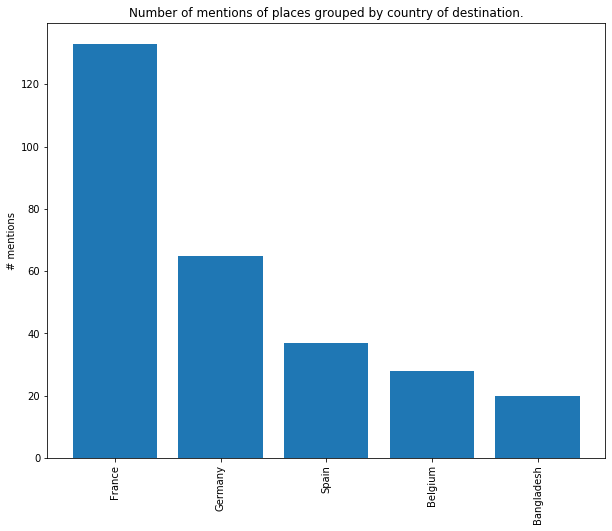

In [18]:
if None in cnt_iso_a3:
    del cnt_iso_a3[None]
labels,values = zip(*cnt_iso_a3.items())
labels = np.array(labels)
values = np.array(values)
sorter = np.argsort(values)[::-1]
labels = labels[sorter][:15]
values = values[sorter][:15]

plt.figure(figsize=[10,8])
plt.title("Number of mentions of places grouped by country of destination.")
plt.bar(range(len(values)),values)
plt.ylabel("# mentions")
_ = plt.xticks(range(len(values)), [iso3166.countries.get(l).name for l in labels], rotation=90)

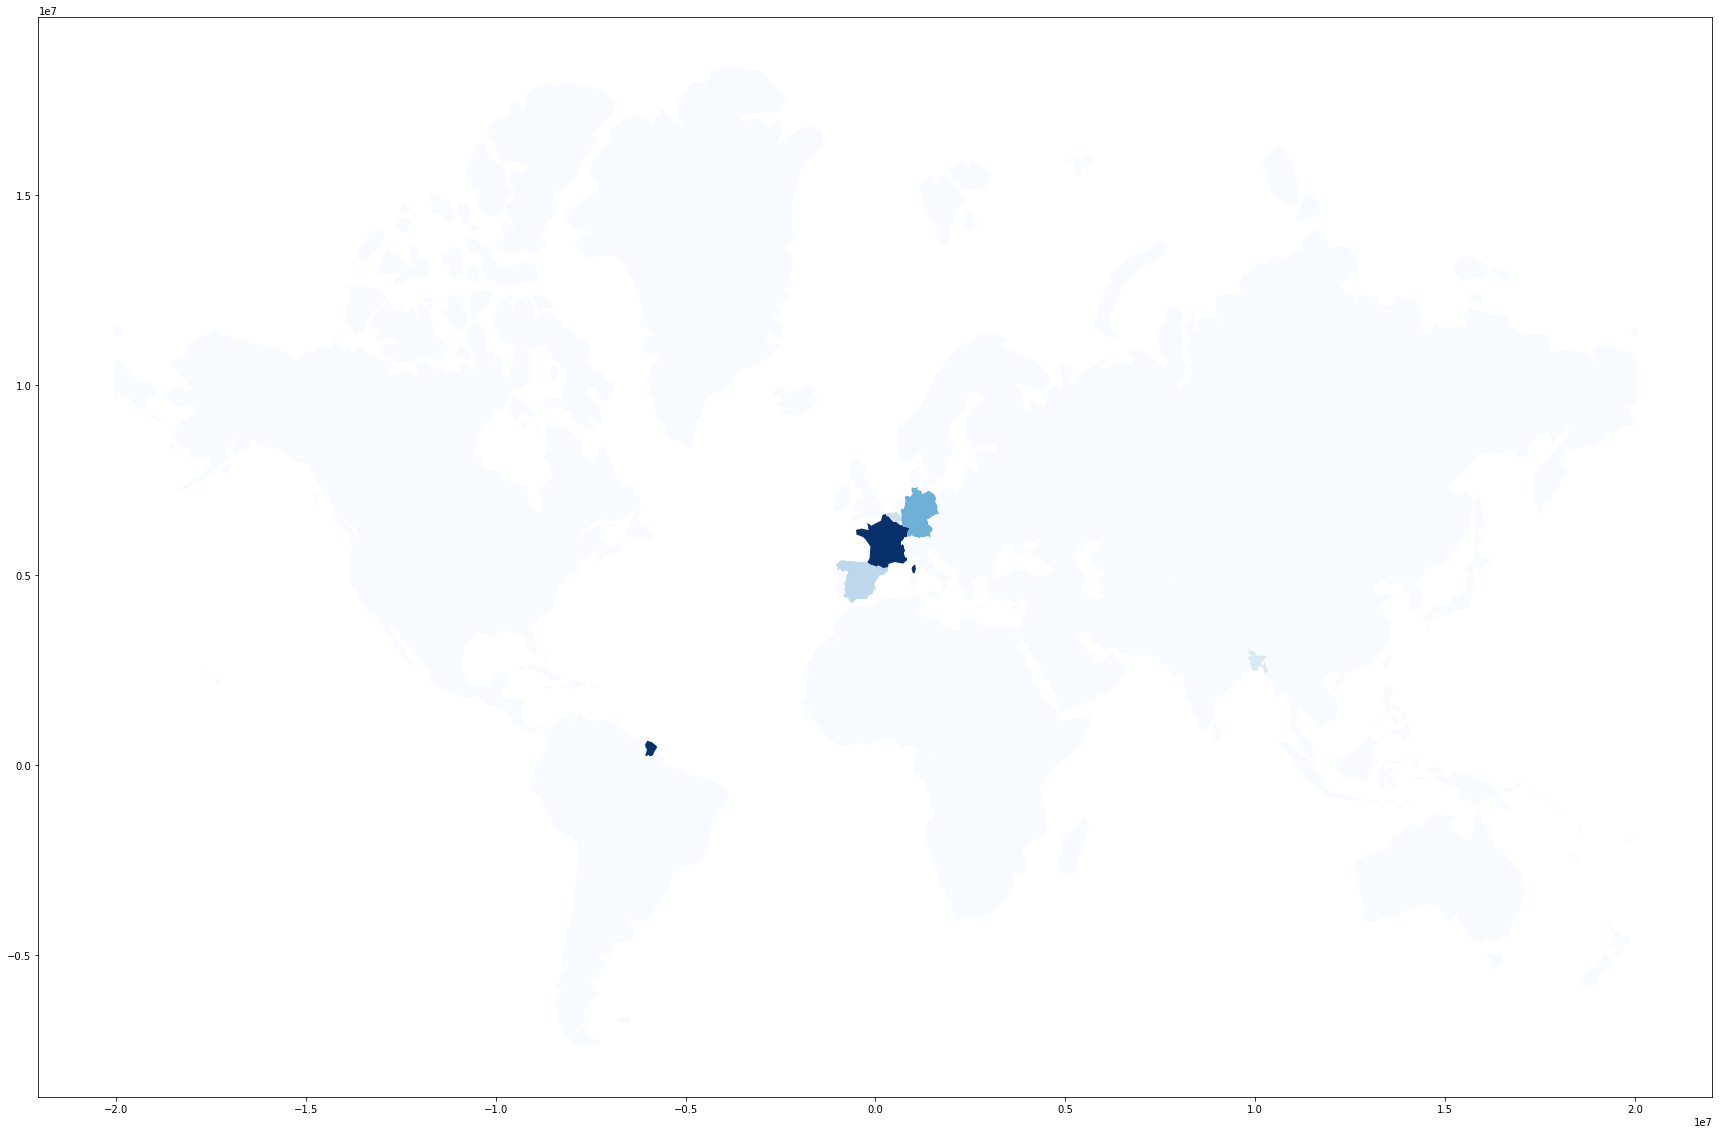

In [20]:
geo_helper.plot_countries(cnt_iso_a3)

## Span Level Custom Attributes

In [21]:
spacy.tokens.Span.set_extension(
    'country_of_entity',
    default=None,
    force=True
)

locations = pd.DataFrame(locations)

for idoc,doc in enumerate(docs):
    clocations = locations[np.logical_and(
        ~locations.country.isnull(),
        locations.idoc == idoc
    )]
    so = standoffs[idoc]
    so.add_spacy_annotations(
        doc,
        clocations.start.tolist(), # TODO
        ["country"]*len(clocations),
        [{"iso_a3":a3} for a3 in clocations.country]
    )
    
    for _, loc in locations[locations.idoc == idoc].iterrows():
        doc[loc.start:loc.end]._.country_of_entity = loc.country
        
        

In [22]:
str_ = so.to_xml()

In [23]:
print(str_[:10000])

<{http://www.tei-c.org/ns/1.0}TEI {http://www.w3.org/XML/1998/namespace}id='FRA0038' {http://www.w3.org/XML/1998/namespace}lang='fr'>
  <{http://www.tei-c.org/ns/1.0}teiHeader>
    <{http://www.tei-c.org/ns/1.0}fileDesc>
      <{http://www.tei-c.org/ns/1.0}titleStmt>
        <{http://www.tei-c.org/ns/1.0}title ref='viaf:182215847'>Waterloo : ELTeC edition</{http://www.tei-c.org/ns/1.0}title>
        <{http://www.tei-c.org/ns/1.0}author ref='viaf:31995972'>Erckmann, Émile (1822-1899)</{http://www.tei-c.org/ns/1.0}author>
        <{http://www.tei-c.org/ns/1.0}respStmt>
          <{http://www.tei-c.org/ns/1.0}resp>principal</{http://www.tei-c.org/ns/1.0}resp>
          <{http://www.tei-c.org/ns/1.0}name>Christof Schöch</{http://www.tei-c.org/ns/1.0}name>
        </{http://www.tei-c.org/ns/1.0}respStmt>
      </{http://www.tei-c.org/ns/1.0}titleStmt>
      <{http://www.tei-c.org/ns/1.0}extent>
        <{http://www.tei-c.org/ns/1.0}measure unit='words'>81303</{http://www.tei-c.org/ns/1.0}me